# Deriving Equations of Motion

Let's first install some useful libraries.

In [1]:
import time
import matplotlib.pyplot as plt
from scipy import linalg
import sympy as sym
import numpy as np
import ae353_spacecraft
import importlib
importlib.reload(ae353_spacecraft)

<module 'ae353_spacecraft' from 'C:\\Users\\seong\\Documents\\3rd Year U of I 2021 Fall Term\\_ISS\\ISS_Learning_Controls\\controls-satellite-demo\\ae353_spacecraft.py'>

## Defining the dynamic model

Specify the physical parameters:
 - `m_body`: Mass of body
 - `Jx_body`, `Jy_body`, `Jz_body`: Inertia values for the body 
 - `m_wheel`: Mass of reaction wheels 
 - `Jx_wheel`, `Jy_wheel`, `Jz_wheel`: Inertia values for the reaction wheels
 - `l_wheel`: Dimension parameter for the wheel itself

In [2]:
m_body = 6.
Jx_body = 10.
Jy_body = 10.
Jz_body = 16.

m_wheel = 1.
Jx_wheel = 0.075
Jy_wheel = 0.075
Jz_wheel = 0.125
l_wheel = 1.1

Derive the equations of motion:

In [3]:
# roll, pitch, yaw angles
phi, theta, psi = sym.symbols('phi, theta, psi')

# angular velocities
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')

# torques
tau_1, tau_2, tau_3, tau_4 = sym.symbols('tau_1, tau_2, tau_3, tau_4')

# resultant torques
lt = sym.nsimplify(l_wheel) * sym.sqrt(2) / 2
T1 = - tau_1 * sym.Matrix([[lt], [0], [lt]])
T2 = - tau_2 * sym.Matrix([[-lt], [0], [lt]])
T3 = - tau_3 * sym.Matrix([[0], [lt], [lt]])
T4 = - tau_4 * sym.Matrix([[0], [-lt], [lt]])
T = T1 + T2 + T3 + T4

# parameters
Jx = sym.nsimplify(Jx_body + 4 * m_wheel * l_wheel**2)
Jy = sym.nsimplify(Jy_body + 4 * m_wheel * l_wheel**2)
Jz = sym.nsimplify(Jz_body + 4 * m_wheel * l_wheel**2)

# rotation matrices
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])

# angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry * Rz).T * ex, Rz.T * ey, ez).inv(), full=True)

# euler's equations
euler = sym.Matrix([[(1 / Jx) * (T[0] + (Jy - Jz) * w_y * w_z)],
                   [(1 / Jy) * (T[1] + (Jz - Jx) * w_z * w_x)],
                   [(1 / Jz) * (T[2] + (Jx - Jy) * w_x * w_y)]])

# equations of motion
f = sym.simplify(sym.Matrix.vstack(M * sym.Matrix([[w_x], [w_y], [w_z]]), euler), full=True)

The equations of motion have this form:

$$\begin{bmatrix} \dot{\phi} \\ \dot{\theta} \\ \dot{\psi} \\ \dot{w_x} \\ \dot{w_y} \\ \dot{w_z} \end{bmatrix} = f\left(\phi, \theta, \psi, w_x, w_y, w_z, \tau_1, \tau_2, \tau_3, \tau_4\right)$$

Here is the function $f$:

In [4]:
f

Matrix([
[                        (w_x*cos(psi) - w_y*sin(psi))/cos(theta)],
[                                     w_x*sin(psi) + w_y*cos(psi)],
[        -w_x*cos(psi)*tan(theta) + w_y*sin(psi)*tan(theta) + w_z],
[-55*sqrt(2)*tau_1/1484 + 55*sqrt(2)*tau_2/1484 - 150*w_y*w_z/371],
[-55*sqrt(2)*tau_3/1484 + 55*sqrt(2)*tau_4/1484 + 150*w_x*w_z/371],
[                -55*sqrt(2)*(tau_1 + tau_2 + tau_3 + tau_4)/2084]])

`lambdify` is used to convert the symbolic equation as a callable function. We apply this function on for the equations of motion generate the function `f_num`

In [5]:
f_num = sym.lambdify((phi,theta,psi,w_x,w_y,w_z,tau_1,tau_2,tau_3,tau_4),f)

## Defining a equilibrium values

These values are specifically chosen so that the control system converges to these desired values. In this case, we want the spacecraft to maintain its attitude given external disturbances. 

In [6]:
phi_e = 0
theta_e = 0
psi_e = 0
wx_e = 0
wy_e = 0
wz_e = 0
tau1_e = 0
tau2_e = 0
tau3_e = 0
tau4_e = 0

Using the equilibirum values and the funtion `f_num` previously defined above, we verify that $f_{eq} = \overline0$ (6 x 1 matrix).

In [7]:
feq = f_num(phi_e,theta_e,psi_e,wx_e,wy_e,wz_e,tau1_e,tau2_e,tau3_e,tau4_e)
feq

array([[ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.]])

## Linearizing the equations of motion 

Variable definitions
 - $x$: Vector that describes the state which are variables of interest
 - $\dot{x}$: Vector that describes the time rate change of state
 - $u$: inputs vector (actuators in the system that we control)
 - $A$: Matrix that relates the states to the time rate change of state
 - $B$: Matrix that relates the inputs to the time rate change of state

To find $A$, apply the `jacobian` function from the `sympy` library. We take partial derivatives of the equations of motion ($f$) with respect to the state ($x$).

$$x = \begin{bmatrix} \phi \\ \theta \\ \psi \\ w_x \\ w_y \\ w_z \end{bmatrix},~A = \frac{\partial f}{\partial x}$$

To find $B$, apply the `jacobian` function from the `sympy` library. We take partial derivatives of the equations of motion ($f$) with respect to the input ($u$).

$$u = \begin{bmatrix} \tau_1 \\ \tau_2 \\ \tau_3 \\ \tau_4 \end{bmatrix},~B = \frac{\partial f}{\partial u}$$

In [8]:
states = [phi,theta, psi, w_x, w_y, w_z]
A_sym = f.jacobian(states)

inputs = [tau_1, tau_2, tau_3, tau_4]
B_sym = f.jacobian(inputs)

We want to linearize about our equilibirium values, so we need to sub in the equilibrium values into the symbolic A and B matrices.

In [9]:
A_num = sym.lambdify(states,A_sym)
B_num = sym.lambdify(inputs,B_sym)

A = A_num(phi_e,theta_e,psi_e,wx_e,wy_e,wz_e)
B = B_num(tau1_e, tau2_e, tau3_e, tau4_e)

## The state equation
We can use these components to create the state equation. 
$$\dot{x} = Ax + Bu$$

## Checking for controllability

To check for controllability, we must verify that system itself is controllable. This can be done with the following equation.

$$u = -Kx$$

$K$ is a constant matrix that is choosen that tells us what our inputs should be, given our state ($x$).

First, we create the controllability matrix ($W$) as shown below in the code block. We can check if the controllability matrix is of full rank, meaning that the system is controllable.

In [10]:
#* Number of states
n = len(B)

#* Initialize the Controllability Matrix (W)
W = B

#* Create the Controllability Matrix (W)
for i in range(1,n):
    new_mat = np.linalg.matrix_power(A, i) @ B
    W = np.block([W,new_mat])

#* Make sure that the rank of the matrix is equal to the number of states
if (np.linalg.matrix_rank(W) == n):
    print("Full rank")
else:
    print("Rank deficient") 

Full rank


## LQR Design (Linear Quadratic Regulator)

LQR is a method useful for optimal controls which involves choosing a $K$ matrix to stabilize the system by balancing emphasis on the state or the input.

The $Q$ matrix describes the penalty for deviating from the state. The $R$ matrix decribes the penalty for using our actuators to get to the desired state. Based on the states or inputs you want to emphasize, it is recommended to set these values to the orders of magnitude of 10. By defining these values as a vector, we can transform it into a diagonalized matrix. This process can be seen in the code below. 

In [11]:
## Designing a Q matrix 
Q_diag = np.array([1,1,1,10,10,10]) #roll, pitch, yaw, wx, wy, wz
Q = np.diag(Q_diag)

## Designing a R matrix
R_diag = np.array([0.1,0.1,0.1,0.1]) #tau1, tau2, tau3, tau4
R = np.diag(R_diag)

#* Making a LQR function that outputs k
#* We solve the Ricatti equation for optimal controller gains
def lqr(A,B,Q,R):
    P = linalg.solve_continuous_are(A,B,Q,R)
    K = linalg.inv(R) @ B.T @ P
    return K
K = lqr(A,B,Q,R)

##* testing to see if the A - BK has all negative eigenvalues 
F = A - B@K
eig = np.linalg.eigvals(F)

print(eig.real < 0)


[ True  True  True  True  True  True]


## Defining the sensor model

Symbolic variables for right ascension $\alpha$ and declination $\delta$ of each star:

In [12]:
alpha, delta = sym.symbols('alpha, delta')

Specify the physical parameters:

In [13]:
# Scope radius
r = 0.8 / 2.1

Define the function

In [14]:
# Position of star in space frame
p_star_in_space = sym.Matrix([[sym.cos(alpha) * sym.cos(delta)],
                              [sym.sin(alpha) * sym.cos(delta)],
                              [sym.sin(delta)]])

# Orientation of body frame in space frame
R_body_in_space = Rx * Ry * Rz

# Position of star in body frame (assuming origin of body and space frames are the same)
p_star_in_body = R_body_in_space.T * p_star_in_space

# Position of star in image frame
p_star_in_image = (1 / sym.nsimplify(r)) * sym.Matrix([[p_star_in_body[1] / p_star_in_body[0]],
                                                       [p_star_in_body[2] / p_star_in_body[0]]])

# Sensor model for each star
g = sym.simplify(p_star_in_image, full=True) 

The sensor model has this form for each star:

$$\zeta = g(\phi, \theta, \psi, \alpha, \delta)$$

Here is the function $g$:

In [15]:
g

Matrix([
[21*((sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi))*sin(delta) - (sin(phi)*sin(psi)*sin(theta) - cos(phi)*cos(psi))*sin(alpha)*cos(delta) - sin(psi)*cos(alpha)*cos(delta)*cos(theta))/(8*((sin(phi)*sin(psi) - sin(theta)*cos(phi)*cos(psi))*sin(delta) + (sin(phi)*sin(theta)*cos(psi) + sin(psi)*cos(phi))*sin(alpha)*cos(delta) + cos(alpha)*cos(delta)*cos(psi)*cos(theta)))],
[                                                                      21*(-sin(alpha)*sin(phi)*cos(delta)*cos(theta) + sin(delta)*cos(phi)*cos(theta) + sin(theta)*cos(alpha)*cos(delta))/(8*((sin(phi)*sin(psi) - sin(theta)*cos(phi)*cos(psi))*sin(delta) + (sin(phi)*sin(theta)*cos(psi) + sin(psi)*cos(phi))*sin(alpha)*cos(delta) + cos(alpha)*cos(delta)*cos(psi)*cos(theta)))]])

## Defining equilibrium values

$g$ is a function of $\alpha$, $\delta$, and other state variables that give us the pixel positions for each star.

In [16]:
# making G a combination of multiple stars, in this case, we are doing 3 stars
alpha1 = 0
delta1 = 0
alpha2 = 0.15
delta2 = 0
alpha3 = 0
delta3 = 0.15

g = np.block([[g.subs([(alpha,alpha1),(delta,delta1)])],[g.subs([(alpha,alpha2),(delta,delta2)])],[g.subs([(alpha,alpha3),(delta,delta3)])]])
g = sym.Matrix(g) #turning an array into a symbolic matrix expression
g

Matrix([
[                                                                                                                                                                                                                                            -21*sin(psi)/(8*cos(psi))],
[                                                                                                                                                                                                                                21*sin(theta)/(8*cos(psi)*cos(theta))],
[21*(-0.149438132473599*sin(phi)*sin(psi)*sin(theta) - 0.988771077936042*sin(psi)*cos(theta) + 0.149438132473599*cos(phi)*cos(psi))/(8*(0.149438132473599*sin(phi)*sin(theta)*cos(psi) + 0.149438132473599*sin(psi)*cos(phi) + 0.988771077936042*cos(psi)*cos(theta)))],
[                                                        21*(-0.149438132473599*sin(phi)*cos(theta) + 0.988771077936042*sin(theta))/(8*(0.149438132473599*sin(phi)*sin(theta)*cos(psi) + 0.149438132

Next step is to find the equilibrium state for $g$. We use `lambdify` to sub in the equilibrium values of $\phi$, $\theta$, and $\psi$.


In [17]:
g_num = sym.lambdify((phi, theta, psi), g)
g_eq = g_num(phi_e, theta_e, psi_e)
g_eq.tolist()

[[-0.0], [0.0], [0.3967299474030241], [0.0], [0.0], [0.3967299474030241]]

## Linearizing the equations of motion

We find the matrix $C$ by taking the Jacobian of $g$ with respect to the state and input.


In [18]:
C_num = sym.lambdify((phi, theta, psi), g.jacobian([phi, theta, psi, w_x, w_y, w_z]))
C = C_num(phi_e,theta_e,psi_e)
C

array([[ 0.        ,  0.        , -2.625     ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  2.625     ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        , -2.68495987,  0.        ,  0.        ,
         0.        ],
       [-0.39672995,  2.625     , -0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.39672995,  0.        , -2.625     ,  0.        ,  0.        ,
         0.        ],
       [-0.        ,  2.68495987,  0.        ,  0.        ,  0.        ,
         0.        ]])

## Checkling for observability

Observability is the ability of a system to estimate any state from a history of sensor measurements. It's useful to have an observer when we have states that we cannot directly measure.

In [19]:
Wo = C

for i in range(1,n):
    row = C @ np.linalg.matrix_power(A,i)
    Wo = np.block([[Wo],[row]])

rank = np.linalg.matrix_rank(Wo)
print(rank)

6


## Optimal Observer Design

We can use LQR to find an optimal observer

In [20]:
Qo = np.diag(np.ones(2*3))
# 2 outputs per star -> 6 total output values

# Low penalty to the actuators
Ro = 0.05 * np.diag([1.,1.,1.,1.,1.,1.])

L = lqr(A.T, C.T, linalg.inv(Ro), linalg.inv(Qo)).T

#The real part of all eigenvalues should be negative
H = A - L@C
eig_o = linalg.eigvals(H)
print(eig_o.real < 0)


[ True  True  True  True  True  True]


## Simulation with Controller

Define the controller using the values calculated above.

In [21]:
class RobotController:
    def __init__(self, A, B, C, K, L, Geq):
        self.dt = 0.01
        self.K = K
        self.L = L
        self.A = A
        self.C = C
        self.B = B
        self.Geq = Geq 
        # All the equilibrium values were chosen to be 0, so they are not defined here
        self.reset()
    
    def reset(self):
        self.xhat = np.zeros((6, 1))
    
    def run(self, p, v):
        z = np.array([p]).T
        y = np.array(z - self.Geq)
        u = -self.K @ self.xhat
        tau = np.array([u[0,0], u[1,0], u[2,0], u[3,0]])
        xhatold = self.xhat
        for i in range(self.xhat.shape[0]):
            if np.isnan(self.xhat[i,0]):
                self.xhat[i,0] = xhatold[i,0]
        self.xhat += self.dt * (self.A @ self.xhat + self.B @ u - self.L @ (self.C@self.xhat  - y))
        return tau

controller = RobotController(A, B, C, K, L, g_eq)

Run the simulator.

elapsed time: 30.0


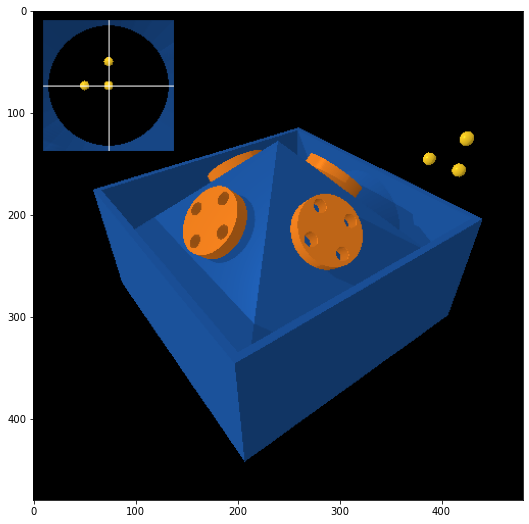

In [22]:
robot = ae353_spacecraft.RobotSimulator(display=True, 
shootingstar = True, 
stars = np.array([[alpha1,delta1],[alpha2,delta2],[alpha3,delta3]]), 
scope_noise=0.1)

# Get snapshot as 480 x 480 x 4 numpy array of RGBA values
rgba = robot.snapshot()

# Display snapshot
plt.figure(figsize=(9, 9))
plt.imshow(rgba)

plt.imsave('my_snapshot.png', rgba)


# Restore the simulation to its initial state
robot.reset()

# Restore the controller to its initial state
controller.reset()

# Choose how long we want to run the simulation, and
# compute the corresponding number of time steps
run_time =  30
num_steps = int(run_time/robot.dt)

# Create a dictionary in which to store results
data = {
    't': np.empty(num_steps, dtype=float),
    'v': np.empty((4, num_steps), dtype=float),
    'p': np.empty((2 * len(robot.stars), num_steps), dtype=float),
    'tau': np.empty((4, num_steps), dtype=float),
    'rpy': np.empty((3, num_steps), dtype=float),
    'angvel': np.empty((3, num_steps), dtype=float),
    'xhat': np.empty((6, num_steps), dtype=float),
}

p = np.zeros(2 * 3) #CHANGE this when changing no. of stars
v = np.zeros(4)
# Run the simulation loop
start_time = time.time()
for step in range(num_steps):
    # Get the current time
    t = robot.dt * step
    pold = p
    vold = v
    # Get the sensor measurements
    p, v = robot.get_sensor_measurements()
    # Ensuring we don't get nan values
    for i in range(p.shape[0]):
        if np.isnan(p[i]):
            p[i] = pold[i]
    # Choose the actuator command (by running the controller)
    tau = controller.run(p, v)
    if tau.shape != (4, ):
        raise Exception(f'invalid desired torques: {tau}')
    
    # Get orientation and angular velocity as ground truth
    rpy, angvel = robot.get_rpy_and_angvel()
        
    # Log the data from this time step
    data['t'][step] = t
    data['v'][:, step] = v
    data['p'][:, step] = p
    data['tau'][:, step] = tau
    data['rpy'][:, step] = rpy
    data['angvel'][:, step] = angvel
    data['xhat'][:, step] = controller.xhat.flatten()
    
    # Send the actuator commands to robot and go forward one time step
    robot.set_actuator_commands(tau)
    robot.step(t=(start_time + (robot.dt * (step + 1))))
    
print(f'elapsed time: {time.time() - start_time:.1f}')



Plot the results of the simulation.

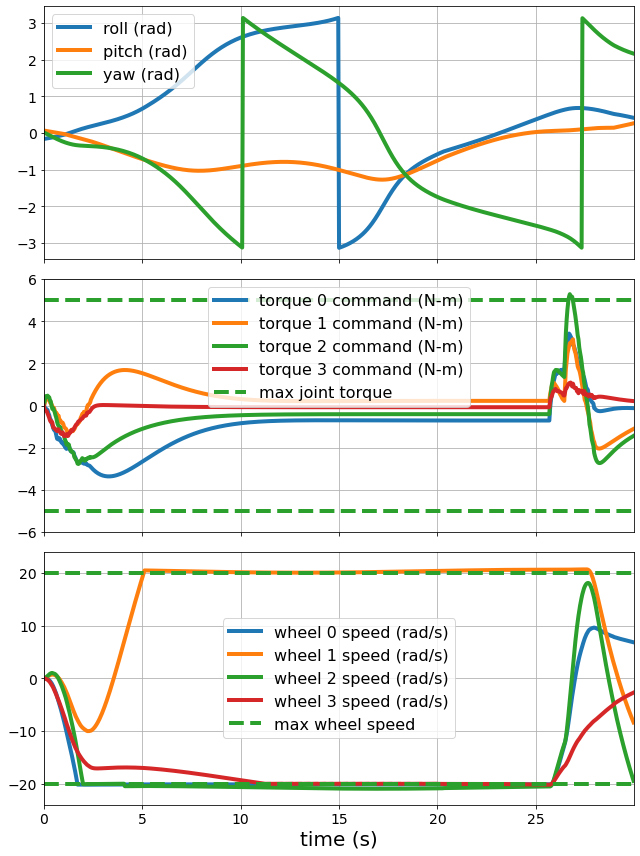

In [23]:
# Create a figure with subplots that all share the same x-axis
fig, (ax_rpy, ax_tau, ax_v) = plt.subplots(3, 1, figsize=(9, 12), sharex=True)

# Roll, pitch, and yaw angles
ax_rpy.plot(data['t'], data['rpy'][0, :], label='roll (rad)', linewidth=4)
ax_rpy.plot(data['t'], data['rpy'][1, :], label='pitch (rad)', linewidth=4)
ax_rpy.plot(data['t'], data['rpy'][2, :], label='yaw (rad)', linewidth=4)
ax_rpy.grid()
ax_rpy.legend(fontsize=16)
ax_rpy.tick_params(labelsize=14)

# Wheel torques
for i in range(4):
    ax_tau.plot(data['t'], data['tau'][i, :], label=f'torque {i} command (N-m)', linewidth=4)
ax_tau.plot(data['t'], np.ones_like(data['t']) * robot.tau_max, '--', label='max joint torque', linewidth=4, color='C2')
ax_tau.plot(data['t'], -np.ones_like(data['t']) * robot.tau_max, '--', linewidth=4, color='C2')
ax_tau.grid()
ax_tau.legend(fontsize=16)
ax_tau.tick_params(labelsize=14)
ax_tau.set_ylim(-1.2 * robot.tau_max, 1.2 * robot.tau_max)

# Wheel speeds
for i in range(4):
    ax_v.plot(data['t'], data['v'][i, :], label=f'wheel {i} speed (rad/s)', linewidth=4)
ax_v.plot(data['t'], np.ones_like(data['t']) * robot.v_max, '--', label='max wheel speed', linewidth=4, color='C2')
ax_v.plot(data['t'], -np.ones_like(data['t']) * robot.v_max, '--', linewidth=4, color='C2')
ax_v.grid()
ax_v.legend(fontsize=16)
ax_v.tick_params(labelsize=14)
ax_v.set_ylim(-1.2 * robot.v_max, 1.2 * robot.v_max)

# Set shared x-axis properties
ax_v.set_xlabel('time (s)', fontsize=20)
ax_v.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()